## Facial Emotion Recognition Gluon

Facial emotion recognition using Gluon API with convolutional neural network implementation. 
We are taking Facial Expression Recognition Challenge dataset for this implementaion.

In [7]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

### Data Preparation is Critical
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
Use this link to download the dataset and prepare the dataset.
We can use this improved dataset from https://github.com/Microsoft/FERPlus/tree/master/data

In [10]:
# 8 Emotions we want to recognize
emotion_table = {0: 'neutral',
                 1: 'happiness',
                 2: 'surprise',
                 3: 'sadness',
                 4: 'anger',
                 5: 'disgust',
                 6: 'fear',
                 7: 'contempt'}

In [12]:
processed_train_images = np.load('data/fer_train_processed_images.npy')
processed_train_labels = np.load('data/fer_train_processed_labels.npy')

In [13]:
print(processed_train_images.shape, processed_train_labels.shape)

(25045, 1, 64, 64) (25045, 8)


In [14]:
from matplotlib import pyplot as plt

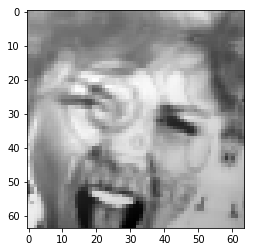

In [15]:
plt.imshow(processed_train_images[987].reshape(64,64), cmap='gray')


In [16]:
processed_test_images = np.load('data/fer_test_processed_images.npy')
processed_test_labels = np.load('data/fer_test_processed_labels.npy')
processed_val_images = np.load('data/fer_val_processed_images.npy')
processed_val_labels = np.load('data/fer_val_processed_labels.npy')


In [17]:
print(processed_test_images.shape, processed_test_labels.shape)

(3137, 1, 64, 64) (3137, 8)


In [18]:
print(processed_val_images.shape, processed_val_labels.shape)

(3191, 1, 64, 64) (3191, 8)


In [19]:
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

In [20]:
# We use HybridSequential network type to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net = gluon.nn.HybridSequential()

# Construct 13 layer VGGNet suggested in the paper
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(8))

In [21]:
# We Hybridize the HybridSequential network to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net.hybridize()

#### Initialize the parameters in Neural Network

In [22]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
nd.waitall()

In [ ]:
# Use MXBOARD here to visualize network
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)

In [ ]:
# Prepare the Trainer with optimizer
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
batch_size = 32
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0025, 'momentum': 0.9})

In [ ]:
# define and prepare module evaluation strategy
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [ ]:
#data loader
train_labels = np.argmax(processed_train_labels, axis=1)
val_labels = np.argmax(processed_val_labels, axis=1)

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_train_images, train_labels), batch_size = batch_size, shuffle=True)
val_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_val_images, val_labels), batch_size = batch_size)

In [ ]:
# train the network 

epochs = 45

train_accuracies = []
losses = []
val_accuracies = []

for e in range(epochs):
    batch = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss).asscalar()
        batch +=1        

    val_accuracy = evaluate_accuracy(val_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    
    losses.append(curr_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print("Epoch %s. Loss: %s, Train_acc %s, Val_acc %s" % (e, curr_loss, train_accuracy, val_accuracy))

In [ ]:
# Test accuracy

acc = mx.metric.Accuracy()
test_labels = np.argmax(processed_test_labels, axis=1)
data_iterator = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_test_images, test_labels), batch_size = 32)
for i, (data, label) in enumerate(data_iterator):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    predictions = nd.argmax(output, axis=1)
    acc.update(preds=predictions, labels=label)
print("Test Accuracy - ", acc.get()[1])

In [ ]:
# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

epochs = range(len(train_accuracies))

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(epochs, losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(epochs, train_accuracies)
p2, = fg2.plot(epochs, val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14)


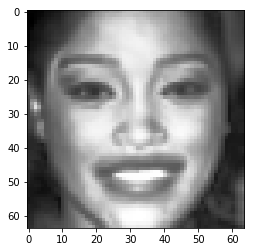

In [24]:
# Example Inference
idx = 98
plt.imshow(processed_test_images[idx].reshape(64,64), cmap='gray')

In [ ]:
print("Actual Emotion - ", emotion_table[test_labels[idx]])

In [ ]:
# Perform Inference
output = net(mx.nd.array(processed_test_images[idx].reshape(1,1,64,64)).as_in_context(ctx))

In [ ]:
print("Predicted Emotion - ", emotion_table[nd.argmax(output, axis=1).asnumpy()[0]])